<a href="https://colab.research.google.com/github/bryanmcelvy/4308_real_time_eeg/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Real-Time Seizure Classification Model

#### Imports

##### Import libraries

In [1]:
''' Import libraries'''
# Built-in Python libraries
import os
import sys

# Custom Functions/Classes
if '/content/4308_real_time_eeg' not in sys.path:
  !git clone https://github.com/bryanmcelvy/4308_real_time_eeg.git
  sys.path.append('/content/4308_real_time_eeg')

from feature_extraction import *
from log_reg_funcs import *

# Google Colab
from google.colab import drive
drive.mount('/content/gdrive')

# 3rd-Party Libraries
## NOTE: matplotlib.pyplot and scipy.signal are needed for the custom functions/classes
import numpy as np
from pandas import DataFrame
from sklearn.model_selection import train_test_split
import tensorflow as tf
try:
  from mne.io import read_raw_edf
except:
  !pip install mne 
  from mne.io import read_raw_edf

Cloning into '4308_real_time_eeg'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 52 (delta 32), reused 36 (delta 16), pack-reused 0
Unpacking objects: 100% (52/52), done.
Mounted at /content/gdrive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 18.9 MB/s 


##### Import dataset

In [2]:
'''Import dataset'''
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/')
dir_path = os.getcwd()
filename = dir_path + '/chb01_03.edf'

with open(filename) as _:
    edf_file = read_raw_edf(input_fname = filename, preload=False, verbose=False);  # Import EEG data from edf file
    fs = edf_file.info['sfreq']  # Sampling Frequency [Hz]
    ch_names = edf_file.ch_names
    # Store channel data in DataFrame
    eeg_df = DataFrame(  
        data = np.transpose(edf_file.get_data()), 
        columns = ch_names
        ).multiply(1E6)  # Convert from [V] to [uV]


<ipython-input-2-c4a0fe074190>:7: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  edf_file = read_raw_edf(input_fname = filename, preload=False, verbose=False);  # Import EEG data from edf file


#### Feature Extraction

In [3]:
feat_names = ['Area', 'Normalized Decay', 'Line Length', 
            'Mean Energy', 'Average Peak Amplitude', 'Average Valley Amplitude',
            'Normalized Peak Number', 'Peak Variation', 'Root Mean Square']

func_names = [findArea, findNormDecay, findLineLength, 
         findMeanEnergy, findAvgPeakAmp, findAvgValleyAmp, 
         findNormPeakNum, findPeakVariation, findRootMeanSquare]

num_segments = int( len(eeg_df) / fs ) # number of time segments (3600)
num_channels = len(ch_names) # number of channels (23)
num_features = len(feat_names) # number of features (9)

time = np.linspace(start=0, stop=num_segments-1, num=num_segments, dtype=int)

y_data = np.array([1 if (t >= 2996 and t <= 3036) else 0 for t in time]) # Correct labels for each time segment
class_labels = {0:'Not Seizure', 1:'Seizure'} # classes to be predicted for each time segment
num_classes = len(class_labels)

# Create np array with dimensions (num_segments X num_features X num_channels) (3600 X 9 X 23)
x_data = np.zeros(
    shape=(
        num_segments,
        num_features, 
        num_channels
    ), dtype=np.float64)

In [4]:
# Perform feature extraction for each time segment across all channels
for t in time:
    for feat_num, _ in enumerate(feat_names):
        for ch_num, ch in enumerate(ch_names):
            start_idx = t * int(fs)
            end_idx = start_idx + int(fs)
            x_data[t][feat_num][ch_num] = func_names[feat_num](eeg_df[ch][start_idx:end_idx])


#### Dataset Preparation

In [5]:
# Split into training/testing/validation sets
x_train, x_tv, y_train, y_tv = train_test_split(
    x_data, y_data,
    train_size=0.80, test_size=0.20,      # 80:20 split between training and test/validation sets
    shuffle=True, random_state=42         # shuffles data using same random seed every time
)

x_test, x_val, y_test, y_val = train_test_split(
    x_tv, y_tv,
    train_size = 0.10, test_size = 0.10,   # Even split btw test and validation sets
    shuffle=True, random_state=42         # same as above
)

In [6]:
# Store data in tensors
x_train = tf.convert_to_tensor(x_train, dtype=np.float32)
x_test = tf.convert_to_tensor(x_test, dtype=np.float32)
x_val = tf.convert_to_tensor(x_val, dtype=np.float32)

y_train = tf.convert_to_tensor(y_train, dtype=np.float32)
y_test = tf.convert_to_tensor(y_test, dtype=np.float32)
y_val = tf.convert_to_tensor(y_val, dtype=np.float32)

In [7]:
# Reshape
x_train = tf.reshape( x_train, shape=( x_train.shape[0], x_train.shape[1]*x_train.shape[2] ) )
x_test = tf.reshape( x_test, shape=( x_test.shape[0], x_test.shape[1]*x_test.shape[2]) )
x_val = tf.reshape( x_val, shape=( x_val.shape[0], x_val.shape[1]*x_val.shape[2]) )

In [8]:
# Normalize
x_norm_train = Normalizer(x_train)
x_norm_test = Normalizer(x_test)
x_norm_val = Normalizer(x_val)

x_train_norm = x_norm_train.norm(x_train)
x_test_norm = x_norm_val.norm(x_test)
x_val_norm = x_norm_val.norm(x_val)

In [9]:
# Load datasets into Dataset objects
train_data = tf.data.Dataset.from_tensor_slices((x_train_norm, y_train))
test_data = tf.data.Dataset.from_tensor_slices((x_test_norm, y_test))
val_data = tf.data.Dataset.from_tensor_slices((x_val_norm, y_val))

# Randomize and separate into batches
batch_size = 400 # Train 400 time segments at a time

train_data = train_data.shuffle(buffer_size=x_train_norm.shape[0], seed=42).batch(batch_size=batch_size)
test_data = test_data.shuffle(buffer_size=x_test_norm.shape[0], seed=42).batch(batch_size=batch_size)
val_data = val_data.shuffle(buffer_size=x_val_norm.shape[0], seed=42).batch(batch_size=batch_size)

#### Training

In [10]:
log_reg_model = LogRegModel()

loop = TrainingLoop()
log_reg_model = loop.train(train_data=train_data, test_data=test_data, num_epochs=200, learn_rate=0.1, model=log_reg_model, output=True)

Training Started...
Epoch: 0	Loss: 6.778	Accuracy: 0.6284
Epoch: 20	Loss:  6.2	Accuracy: 0.6409
Epoch: 40	Loss: 6.078	Accuracy: 0.6356
Epoch: 60	Loss: 6.464	Accuracy: 0.6278
Epoch: 80	Loss: 5.583	Accuracy: 0.6669
Epoch: 100	Loss: 5.655	Accuracy: 0.6534
Epoch: 120	Loss: 6.597	Accuracy: 0.6316
Epoch: 140	Loss: 6.63	Accuracy: 0.6281
Epoch: 160	Loss: 5.501	Accuracy: 0.6625
Epoch: 180	Loss: 7.194	Accuracy: 0.6116
...Complete.
––––––––––––––––––––––––––––––
Final Scores:
         Metric                  Training                Validation                  Test           
          Loss:              5.737489700317383       10.527626037597656        8.908019065856934    
        Accuracy:           0.6425000429153442               0.5              0.5694444179534912    


#### Performance Evaluation

Plotting...Done.


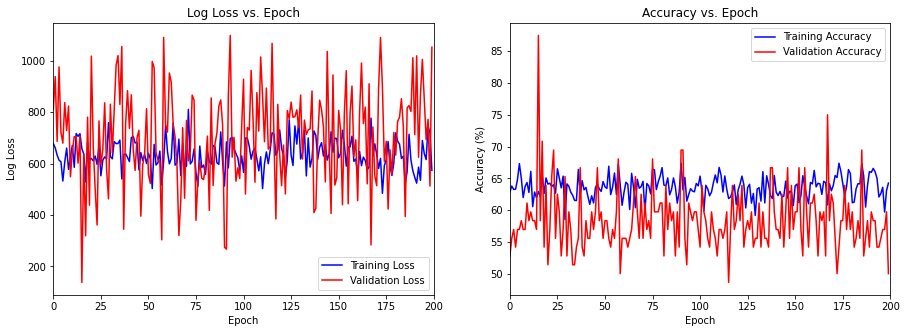

In [11]:
loop.plot()

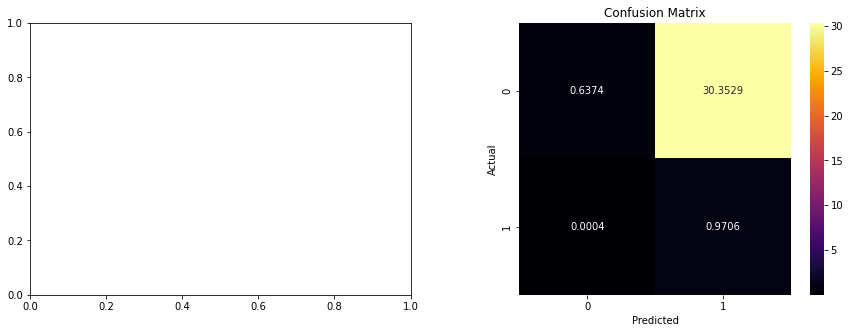

In [12]:
y_pred_train = log_reg_model(x_train_norm, train=False)
y_pred_test = log_reg_model(x_test_norm, train=False)

y_class_train = predict(y_pred_train)
y_class_test = predict(y_pred_test)

confusion(y_pred=y_class_train, y_true=y_train)